**Human Connectome Project: resting state fMRI**

n_subjects: `812` (ages 22-35)  
n_timepoints: `4800` x 0.72s = 3456s = 57.6min  
n_regions: `15, 25, 50, 100, 300`  

regions defined by decomposing group-level ICA maps at various spatial scales

timeseries preprocessing:
1. highpass filtered
2. mean-centered
3. removal of phyiological + motion confounds using linear regression:  
    ICA noise components classified by FIX algorithm +   24 head motion parameters

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from nilearn import plotting
from scipy import signal
from scipy.optimize import curve_fit
from scipy.stats import linregress
from statsmodels.tsa.ar_model import AutoReg

from src import acf_utils, timescale_utils

n_subjects, n_regions, n_timepoints = 10, 300, 4800
sampling_rate = 1 / 0.72
hcp_coordinates = np.load("./data/nregions-300_coordinates.npy")
hcp_sizes = np.load("./data/nregions-300_sizes.npy")
mni_center = [0, -12, 4]  # thalamus coordinates
# euclidean distance to the thalamus (brain center)
distances = np.linalg.norm(hcp_coordinates - mni_center, axis=1)

# initialize estimators
acf = acf_utils.ACF(n_jobs=-2)
ols = timescale_utils.OLS(n_jobs=-2)
nls = timescale_utils.NLS(n_jobs=-2)

Xs = np.load("./data/nsubjects-10_nregions-300_hcp.npy").astype(np.float32)
Xs.shape

(10, 4800, 300)

**time domain analysis**

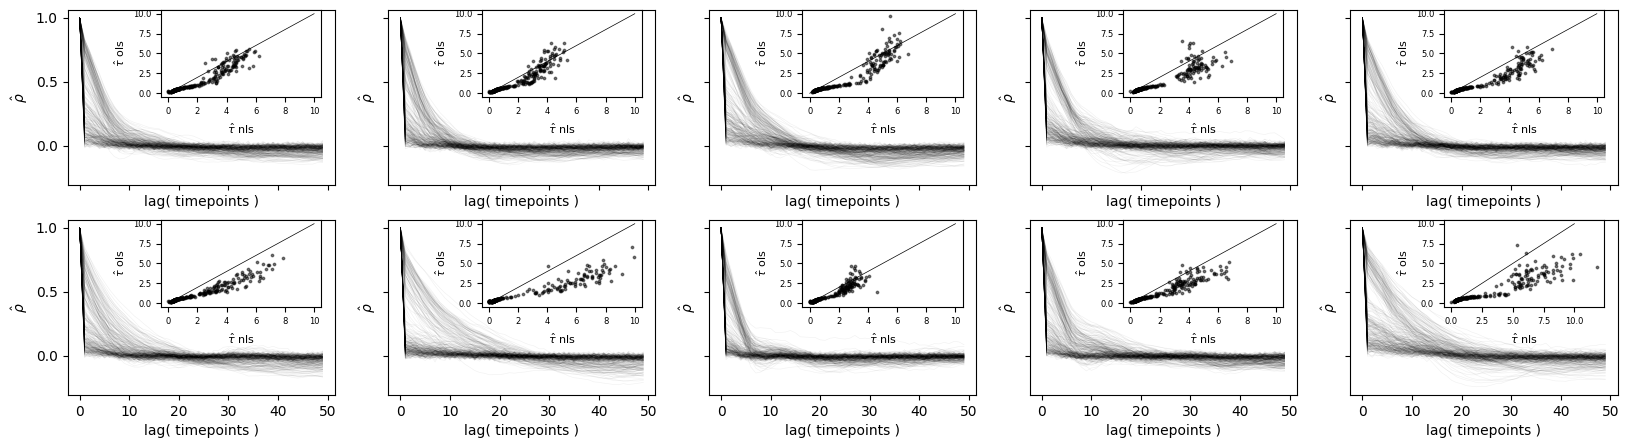

In [2]:
# !!! 10 sec runtime !!!

fig, axs = plt.subplots(nrows=2, ncols=n_subjects // 2, figsize=(20, 5), sharex=True, sharey=True)
axs = axs.flatten()

for idx, ax in enumerate(axs):
    X_acf_ = acf.fit_transform(Xs[idx], n_timepoints)
    nls.fit(Xs[idx], n_timepoints)
    ols.fit(Xs[idx], n_timepoints)

    ax.plot(X_acf_[:50, :], alpha=0.05, c="k", lw=0.5)
    ax.set_yticks([0, 0.5, 1])
    ax.set_xlabel("lag( timepoints )")
    ax.set_ylabel(r"$\hat \rho$")

    inset_ax = ax.inset_axes([0.35, 0.5, 0.6, 0.5])
    inset_ax.scatter(nls.estimates_["tau"], ols.estimates_["tau"], s=3, alpha=0.5, c="k")
    inset_ax.plot([0, 10], [0, 10], c="k", lw=0.5)  # 1:1 line
    inset_ax.tick_params(axis="both", which="major", labelsize=6)
    inset_ax.set_xlabel(r"$\hat{\tau}$ nls", fontsize=8)
    inset_ax.set_ylabel(r"$\hat{\tau}$ ols", fontsize=8)

**frequency domain analysis**

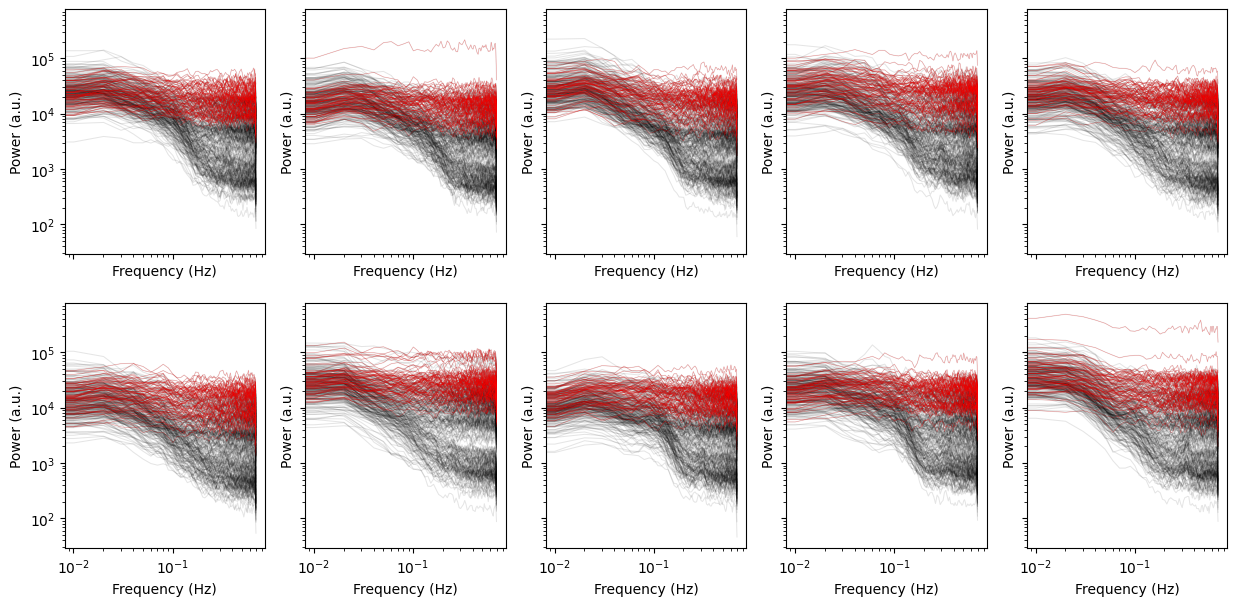

In [3]:
# !!! 10 sec runtime !!!

fig, axs = plt.subplots(nrows=2, ncols=n_subjects // 2, figsize=(15, 7), sharex=True, sharey=True)
axs = axs.flatten()

outliers = np.zeros(n_regions)
for idx, ax in enumerate(axs):
    freqs, powers = signal.welch(Xs[idx].T, fs=sampling_rate, nperseg=int(sampling_rate * 100))

    # find the flattest 25% of PDSs
    n_select = int(0.25 * n_regions)
    x = np.log10(freqs[1:])
    slopes = [linregress(x, np.log10(power[1:])).slope for power in powers]
    idx = np.argsort(np.abs(slopes))[:n_select]
    outliers[idx] += 1

    ax.loglog(np.tile(freqs, (n_regions, 1)).T, powers.T, color="k", lw=0.75, alpha=0.1)
    ax.loglog(np.tile(freqs, (n_select, 1)).T, powers[idx].T, color="r", lw=0.25, alpha=0.5)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Power (a.u.)")

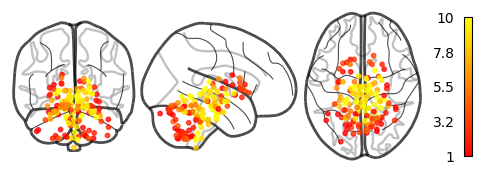

In [4]:
# location of regions with flattest spectrum
fig, ax = plt.subplots(figsize=(6, 2))
idx = np.where(outliers != 0)[0]
plotting.plot_markers(
    outliers[idx],
    hcp_coordinates[idx],
    node_cmap="autumn",
    alpha=0.75,
    node_size=10,
    annotate=False,
    axes=ax,
)

**estimate timescale maps**

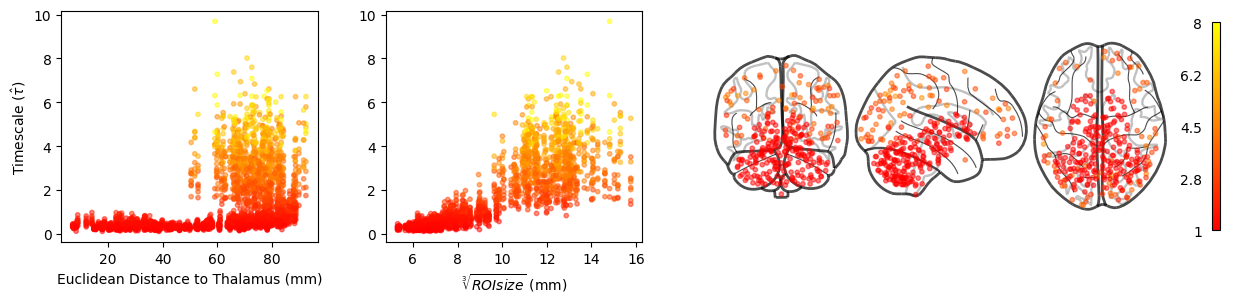

In [5]:
timescales = [ols.fit(X, X.shape[0])["tau"] for X in Xs]

# plot results
fig, axs = plt.subplots(1, 3, figsize=(15, 3), gridspec_kw=dict(width_ratios=[0.5, 0.5, 1]))

for timescale in timescales:
    axs[0].scatter(
        distances,
        timescale,
        alpha=0.5,
        s=10,
        c=timescale,
        cmap="autumn",
    )

axs[0].set_xlabel(f"Euclidean Distance to Thalamus (mm)")
axs[0].set_ylabel(r"Timescale ($\hat \tau$)")

for timescale in timescales:
    axs[1].scatter(hcp_sizes, timescale, alpha=0.5, s=10, c=timescale, cmap="autumn")

axs[1].set_xlabel(r"$\sqrt[3]{ROIsize}$ (mm)")

plotting.plot_markers(
    np.mean(timescales, axis=0),
    hcp_coordinates,
    axes=axs[2],
    node_cmap="autumn",
    alpha=0.5,
    node_vmin=1,
    node_vmax=8,
    node_size=10,
    annotate=False,
)